In [ ]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/masinsko/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/masinsko


120 30


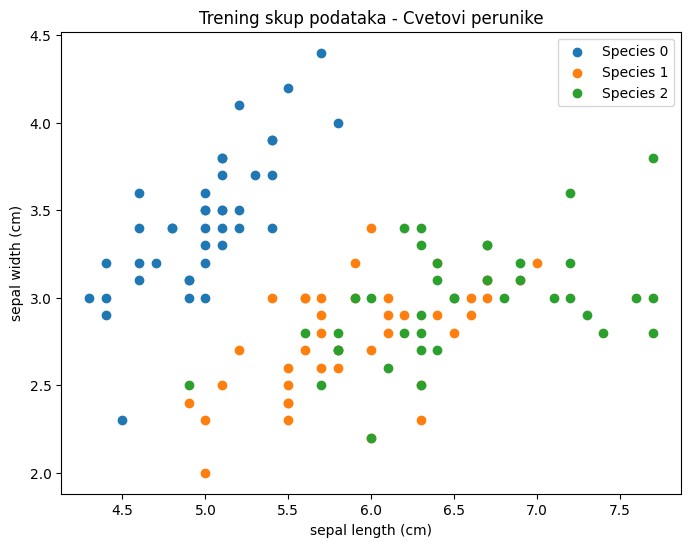

Test example:  1/30 | Predicted: 1 | Actual: 1 | Match: True
Test example:  6/30 | Predicted: 0 | Actual: 0 | Match: True
Test example: 11/30 | Predicted: 2 | Actual: 2 | Match: True
Test example: 16/30 | Predicted: 2 | Actual: 1 | Match: False
Test example: 21/30 | Predicted: 0 | Actual: 0 | Match: True
Test example: 26/30 | Predicted: 1 | Actual: 2 | Match: False
26 matches out of 30 examples
Test set accuracy: 0.8666666666666667


In [ ]:
class KNN:

    def __init__(self, nb_features, nb_classes, data, k, weighted = False):
        self.nb_features = nb_features
        self.nb_classes = nb_classes
        self.k = k
        self.weighted = weighted
        self.X = tf.convert_to_tensor(data['x'], dtype=tf.float32)
        self.Y = tf.convert_to_tensor(data['y'], dtype=tf.int32)

    # ako imamo odgovore za upit racunamo i accuracy
    def predict(self, query_data):

        nb_queries = len(query_data['x'])

        matches = 0
        for i in range(nb_queries):

            #racunamo euklidsku udaljenost na kvadrat i uzimamo min k
            dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, query_data['x'][i])), axis=1))
            _, idxs = tf.nn.top_k(-dists, self.k)

            classes = tf.gather(self.Y, idxs)
            dists = tf.gather(dists, idxs)

            if self.weighted:
                w = 1 / self.dists  # Paziti na deljenje sa nulom.
                w = tf.where(tf.math.is_inf(w), 0, w)
            else:
                w = tf.fill([self.k], 1/self.k)

            #svaki red mnozimo svojim glasom i sabiramo glasove po kolonama
            w_col = tf.reshape(w, (self.k, 1))
            classes_one_hot = tf.one_hot(classes, self.nb_classes)
            scores = tf.reduce_sum(w_col * classes_one_hot, axis=0)

            #hipoteza ce biti klasa sa najvise glasova
            hyp = tf.argmax(scores)

            if query_data['y'] is not None:
                actual = query_data['y'][i]
                match = (hyp == actual)
                if match:
                    matches += 1
                if i % 5 == 0:
                    print(f'Test example: {i+1:2}/{nb_queries} | Predicted: {hyp} | Actual: {actual} | Match: {match}')

        accuracy = matches / nb_queries
        print(f'{matches} matches out of {nb_queries} examples')
        print(f'Test set accuracy: {accuracy}')


filename = 'iris.csv'
all_data = pd.read_csv(filename, usecols=['sepal_length','sepal_width', 'species'])
all_data_wn = all_data.dropna(ignore_index=True)

X = all_data_wn[['sepal_length', 'sepal_width']].values
Y = pd.Categorical(all_data_wn['species']).codes

indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)

nb_train = len(train_y)
nb_test = len(test_y)
print(nb_train, nb_test)

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.scatter(train_x[train_y == i, 0], train_x[train_y == i, 1], label=f'Species {i}')

plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('Trening skup podataka - Cvetovi perunike')
plt.legend()
plt.show()

train_x = np.reshape(train_x, [nb_train, -1])
test_x = np.reshape(test_x, [nb_test, -1])

#knn na testovima
nb_features = 2
nb_classes = 3
k = 3
train_data = {'x': train_x, 'y': train_y}
knn = KNN(nb_features, nb_classes, train_data, k, weighted = False)
knn.predict({'x': test_x, 'y': test_y})